<a href="https://colab.research.google.com/github/Kadigadi/ML/blob/patch-1/AI_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2
### Прогнозирование временных рядов с помощью аппарата ИНС
Подготовили: Поминова Алёна, Жарковский Никита, Цыганкова Елизавета 

TODO: удалить
Источник http://www.bizkit.ru/2019/11/11/15143/

In [88]:
from google.colab import files 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, SimpleRNN
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input


In [89]:
#Считываем предварительно сгенрированные данные с помощью pandas
base_data = pd.read_csv('lab2.csv', sep=',')#/content/lab2_4_chnls.csv #'lab2.csv'
print(base_data.shape)

#Выводим пять первых строк
base_data.head()

(200, 7)


,ti,f,empty,x1,x2,x3,y
0,0.0,0.000000,NaN,0.000000,0.998334,1.986693,6.442177
1,0.1,0.998334,NaN,0.998334,1.986693,2.955202,7.173561
2,0.2,1.986693,NaN,1.986693,2.955202,3.894183,7.833269
3,0.3,2.955202,NaN,2.955202,3.894183,4.794255,8.414710
4,0.4,3.894183,NaN,3.894183,4.794255,5.646425,8.912074


# Подготовка данных

In [91]:
#Загружаем выборку и делаем предобработку, убрав 3 первые колонки
def getData(df):
  data = df
  return data.drop(columns=['ti', 'f', 'empty'], axis=1).astype(float)
#Получаем данные из файла
def getDataFromFile(fileName):
  df = pd.read_csv(fileName, sep=',') #Считываем файл с помощью pandas
  return getData(df)                  #Возвращаем считанные данные из файла

In [92]:
#Считываем данные из файла
data = getDataFromFile('lab2.csv')
print(data.head(5))
print(data.shape)
print(data.tail(10))

         x1        x2        x3         y
0  0.000000  0.998334  1.986693  6.442177
1  0.998334  1.986693  2.955202  7.173561
2  1.986693  2.955202  3.894183  7.833269
3  2.955202  3.894183  4.794255  8.414710
4  3.894183  4.794255  5.646425  8.912074
(200, 4)
           x1        x2        x3         y
190  1.498772  2.478342  3.433149  7.515734
191  2.478342  3.433149  4.353654  8.136737
192  3.433149  4.353654  5.230658  8.676441
193       NaN       NaN       NaN       NaN
194       NaN       NaN       NaN       NaN
195       NaN       NaN       NaN       NaN
196       NaN       NaN       NaN       NaN
197       NaN       NaN       NaN       NaN
198       NaN       NaN       NaN       NaN
199       NaN       NaN       NaN       NaN


In [93]:
data = data[0:193]
data.tail(10)

,x1,x2,x3,y
183,-5.223086,-4.345656,-3.424806,1.498772
184,-4.345656,-3.424806,-2.469737,2.478342
185,-3.424806,-2.469737,-1.489990,3.433149
186,-2.469737,-1.489990,-0.495356,4.353654
187,-1.489990,-0.495356,0.504227,5.230658
188,-0.495356,0.504227,1.498772,6.055399
189,0.504227,1.498772,2.478342,6.819636
190,1.498772,2.478342,3.433149,7.515734
191,2.478342,3.433149,4.353654,8.136737
192,3.433149,4.353654,5.230658,8.676441


In [ ]:
#Функция зашумления y
def create_noise_data(idata):
    
    noise = np.random.uniform(low=0, high=9, size=idata.shape[0])
    
    for i in range(0, idata.shape[0]):
        if noise[i] <= 2:
            noise_pr = np.random.uniform(low=1e-10, high=9)
            idata['y'][i] = idata['y'][i]*(1+noise_pr/100)
        if noise[i] >= 7:
            noise_pr = np.random.uniform(low=1e-10, high=9)
            idata['y'][i] = idata['y'][i]*(1-noise_pr/100)    

    return idata

In [94]:
data = create_noise_data(data)
data

,x1,x2,x3,y
0,0.000000,0.998334,1.986693,6.442177
1,0.998334,1.986693,2.955202,7.173561
2,1.986693,2.955202,3.894183,7.380309
3,2.955202,3.894183,4.794255,8.414710
4,3.894183,4.794255,5.646425,8.496974
...,...,...,...,...
188,-0.495356,0.504227,1.498772,6.055399
189,0.504227,1.498772,2.478342,6.819636
190,1.498772,2.478342,3.433149,7.620541
191,2.478342,3.433149,4.353654,8.136737


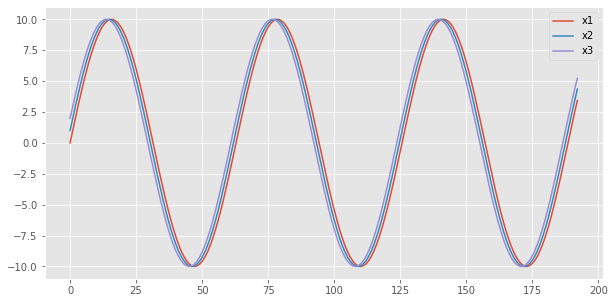

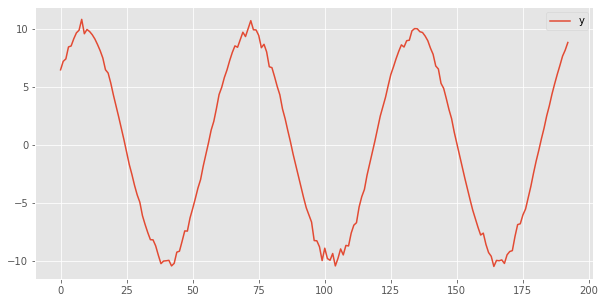

In [95]:
#Отображаем исходные данные от точки start и длиной step
start = 0 #С какой точки начинаем
step = data.shape[0] #Сколько точек отрисуем
#Заполняем текстовые названия каналов данных
chanelNames = list(data.columns) # ['x1', 'x2', 'x3']
#Рисуем все графики данных
plt.figure(figsize=(10,5))
for i in range(3):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data.iloc[start:start+step, i], label=chanelNames[i])
plt.legend()
plt.show()
#Канал y
plt.figure(figsize=(10,5))
plt.plot(data.iloc[start:start+step, 3], label="y")
plt.legend()
plt.show()

# Код подготовки данных для временного ряда

In [96]:
#data - Numpy array
def DataNormalization(data, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  resData = data.iloc[:,Channels]
  if (len(resData.shape) == 1): #Если размерность входного массива - одномерный вектор, 
    print("Add one dimension")
    resData = np.expand_dims(resData, axis=1) #то добавляем размерность
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)

In [97]:
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization, yNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
def getXTrainFromTimeSeries(data, xLen , xChannels, yChannels, stepsForward, xNormalization, yNormalization, valLen):
  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)
  #xData = np.array(data.iloc[:,xChannels]) # без нормализациии совсем плохо получается
  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)
  #yData = np.array(data.iloc[:,yChannels])

  #Формируем xTrain
  #xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(0, xData.shape[0] - xLen + 1, xLen)]) #Разбиваем исходный ряд на куски xLen с шагом xLen (без 'раскусывания', результат хуже)
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])  #Разбиваем исходный ряд на куски xLen с шагом 1
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    #yTrain = np.array([yData[i:i + xLen, [0]] for i in range(0, yData.shape[0] - xLen + 1, xLen)]) #с шагом xLen (без 'раскусывания', результат хуже)
    yTrain = np.array([yData[i:i + stepsForward, [0]] for i in range(xLen, yData.shape[0] + 1 - stepsForward)]) #с шагом 1
  else:
    yTrain = np.array([yData[i, [0]] for i in range(xLen, yData.shape[0] + 1 - stepsForward)]) #с шагом 1

  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = 1

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [98]:
#Формируем параметры загрузки данных
xLen = 10
stepsForward = 1 
xChannels = range(data.drop(['y'], axis=1, inplace=False).shape[1])
yChannels = [3] #4 #5
xNormalization = 0
yNormalization = 0
valLen = 50#round(data.shape[0]/xLen*0.2)

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, valLen)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(132, 10, 3)
(132, 1)
(50, 10, 3)
(50, 1)


Epoch 1/20
7/7 [==============================] - 1s 31ms/step - loss: 0.9793 - val_loss: 0.6295
Epoch 2/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6945 - val_loss: 0.4971
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.5283 - val_loss: 0.4676
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4918 - val_loss: 0.4596
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4257 - val_loss: 0.4263
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4183 - val_loss: 0.3749
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3331 - val_loss: 0.3179
Epoch 8/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3114 - val_loss: 0.2689
Epoch 9/20
7/7 [==============================] - 0s 9ms/step - loss: 0.2930 - val_loss: 0.2352
Epoch 10/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2280 - val_loss: 0.2049
Epoch 11/20
7/7 [==================

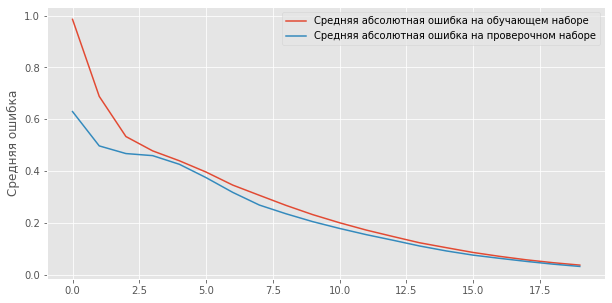

In [99]:
modelC = Sequential()
modelC.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))
history = modelC.fit(xTrain, 
                    yTrain, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# Визуализация результатов

In [100]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

In [101]:
#Функция визуализирует графики прогноза сети и правильных ответов
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(10,5))
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Факт')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [102]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

In [103]:
yValUnscaled.reshape(yValUnscaled.shape[0])

array([  6.51373444,   5.27726392,   4.84728351,   3.96740573,
         3.03118357,   2.24010768,   1.07753652,   0.07963184,
        -0.9190685 ,  -1.8969272 ,  -2.87903317,  -3.82071417,
        -4.73926972,  -5.63742616,  -6.38106682,  -7.11785342,
        -7.78352079,  -7.61950682,  -8.58640318,  -9.29124013,
        -9.61397492, -10.48856813,  -9.96900066,  -9.99774431,
        -9.9265938 , -10.23063636,  -9.48844498,  -9.20553563,
        -9.12707676,  -7.90346021,  -6.88468727,  -6.81313766,
        -6.04832822,  -5.54267661,  -4.58150824,  -3.59488252,
        -2.46973662,  -1.42341143,  -0.49535641,   0.50422688,
         1.42100226,   2.47834208,   3.35154708,   4.3536536 ,
         5.23065765,   6.0553987 ,   6.8196362 ,   7.62054064,
         8.13673737,   8.79648933])

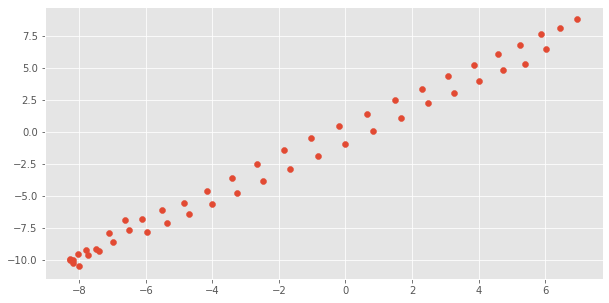

In [104]:
import matplotlib
matplotlib.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.scatter(predVal, yValUnscaled)
plt.show()

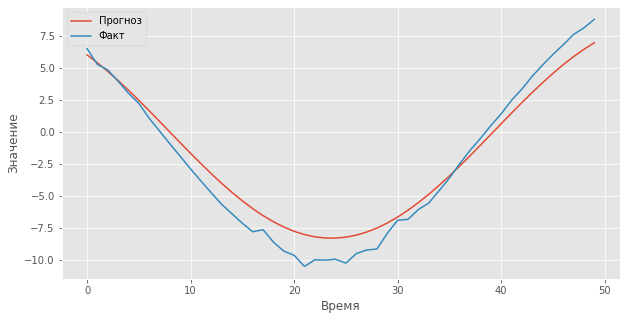

In [105]:
showPredict(0, predVal.shape[0], 0, predVal, yValUnscaled)